# Society for Neuroscience Annual Meeting, 2022
# \#8587 Population spike-synchrony contributes to the spectral exponent of aperiodic neural activity
#### M. W. Preston, S. Fei, B. Voytek
## Poster Panel \#0: Simulating correlated spike trains

### Set-up

#### Imports

In [1]:
# general imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable

In [2]:
# spike analysis toolboxes

# elephant
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient, covariance

# elephant reqs
import neo
import quantities as pq


In [3]:
# project-specific imports
import sys
sys.path.append('C:/users/micha/projects/sfn_2022//scripts')
from utils import sim_ou_process, get_spike_times

#### Settings

In [4]:
# directories
PATH = "C:/Users/micha/projects/sfn_2022"
DIR_FIG = PATH + "/figures"
DIR_DATA = PATH + "/data"

In [5]:
# simulation settings
N_SECONDS = 5
FS = 1000 # sampling frequency
N_NEURONS = 100
MEAN_RATE = 10 # average rate of each neuron (Hz)

# random process params
ALPHA = 1.
TAU_C = 25 / 1000

In [6]:
# figure appearance
plt.style.use(PATH + '/stylelib/sfn_2022.mplstyle')
COLORS = ["#7570b3", "#3FAA96", "#F39943"]

# figure size
FIG_WIDTH = 18
# FIG_HEIGHT = 9

#### Functions

In [7]:
def sample_spikes(rand_process, fs, n_neurons=30):
    """
    sample spikes from random process

    Parameters
    ----------
    rand_process : float, array
        random process.
    fs : float
        sampling frequency,
    n_neurons : float, array
        number of neurons in population. The default is 30.        

    Returns
    -------
    spikes : int, 2D array   
        spike trains.

    """
    # generate spikes from OU process
    spikes = np.zeros([n_neurons, len(rand_process)])

    # turn rates into spikes
    for j_bin in range(len(rand_process)):
        for i_neuron in range(n_neurons):
            if rand_process[j_bin] / fs > np.random.uniform():
                spikes[i_neuron, j_bin] = 1
    
    return spikes

In [8]:
def autocorr(x, maxlag):
    """ 
    compute autocorrelation
    soure: https://mark-kramer.github.io/Case-Studies-Python/08.html#autocorrelations

    Parameters
    ----------
    x : float
        signal / data for which to compute autocorreltation
    maxlag : int
        number of lags to compute

    Returns
    -------
    xcorr : float
        autocorrelation of x.

    """
    
    xcorr = np.correlate(x - x.mean(), x - x.mean(), 'full')  # Compute the autocorrelation
    xcorr = xcorr / xcorr.max()                               # Convert to correlation coefficients
    xcorr = xcorr[int(xcorr.size//2-maxlag-1) : int(xcorr.size//2+maxlag+1)] # Return only requested lags
    lags = np.linspace(-maxlag, maxlag, len(xcorr))
    
    return xcorr, lags

### Main

Text(0.5, 1.0, 'Expected firing rate')

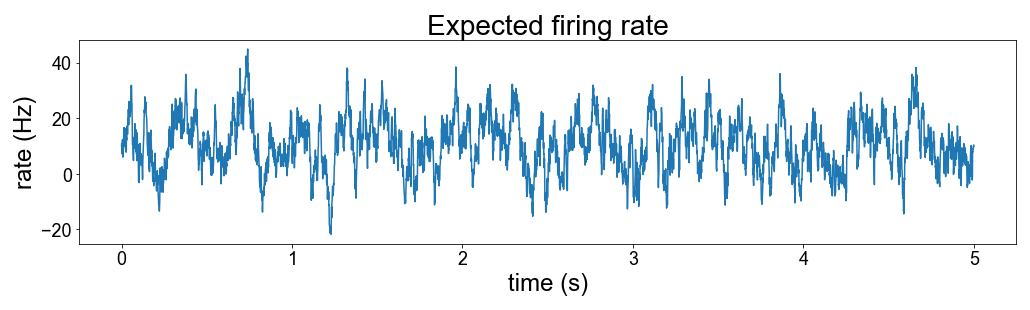

In [9]:
rand_process, time = sim_ou_process(N_SECONDS, FS, mu=MEAN_RATE, sigma=MEAN_RATE, tau=TAU_C)

fig, ax = plt.subplots(figsize=[14,4])
ax.plot(time, rand_process)
ax.set(xlabel="time (s)", ylabel="rate (Hz)")
ax.set_title("Expected firing rate")

[Text(0.5, 0, 'time (s)'), Text(0, 0.5, 'neuron #')]

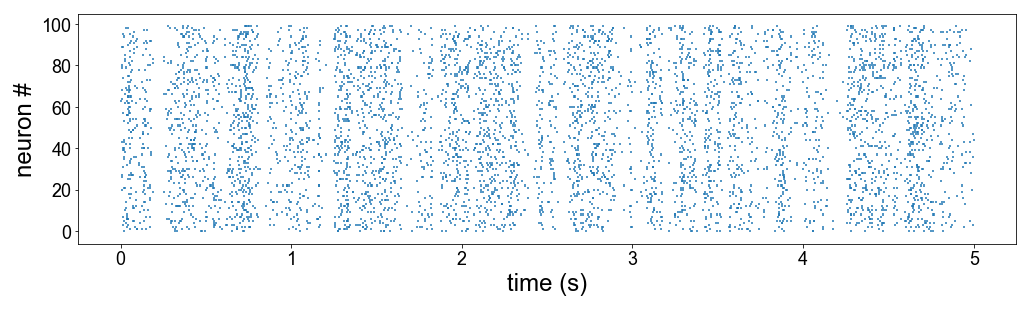

In [10]:
# sample spikes from random process
spikes = sample_spikes(rand_process, FS, N_NEURONS)

# get spike times
spike_times = []
for i_cell in range(len(spikes)):
    spike_times.append(get_spike_times(spikes[i_cell], time))
    
# plot
fig, ax = plt.subplots(figsize=[14,4])
ax.eventplot(spike_times)
ax.set(xlabel="time (s)", ylabel="neuron #")
# ax.set_title("")


[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Neuron #')]

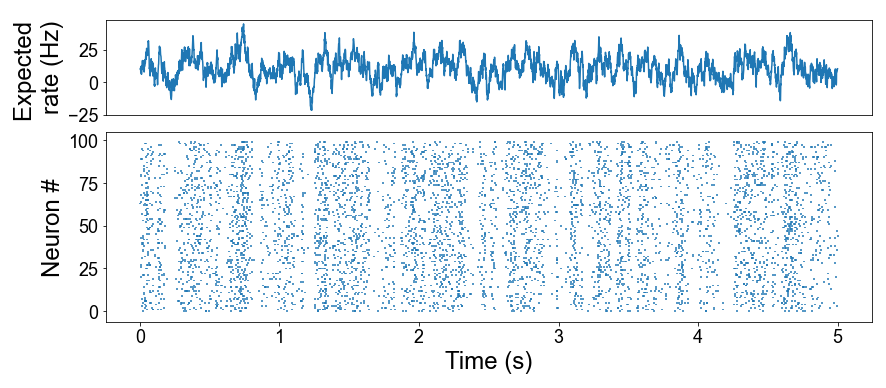

In [11]:
# create figure and gridspec
fig = plt.figure(figsize=[12,5])
spec = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[1,2])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

# plot subplot 1
ax1.plot(time, rand_process)
ax1.set(xlabel="", ylabel="Expected \nrate (Hz)")
# ax1.set_title("Expected firing rate")
ax1.set_xticks([])

# plot subplot 2
ax2.eventplot(spike_times)
ax2.set(xlabel="Time (s)", ylabel="Neuron #")
# ax2.set_title('Population spiking activity')



[Text(0.5, 0, 'Lag (ms)'), Text(0, 0.5, 'Autocorrelation')]

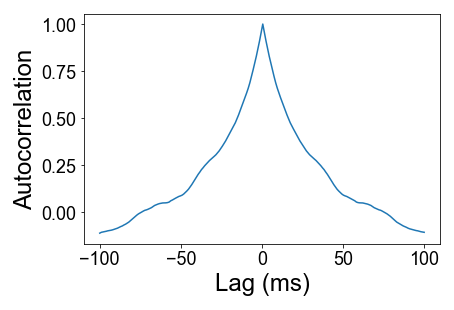

In [12]:
# compute acorr
xcorr, lags = autocorr(x=rand_process, maxlag=100)
 
# plot 
fig, ax = plt.subplots()
ax.plot(lags*FS/1000, xcorr)
ax.set(xlabel="Lag (ms)", ylabel="Autocorrelation")
# ax.set_title("Autocorrelation of OU process")


In [13]:
# compute correlation/covarience measures

# inti
n_neurons = len(spike_times)
corr_mat = []
spike_trains = []

st = spike_times
for i_unit in range(len(st)):
    # skip units withou spikes
    if np.ndim(st[i_unit]) == 0: continue
    if len(st[i_unit]) == 0: continue
    # create spike train
    st_i = neo.SpikeTrain(st[i_unit]*pq.s, N_SECONDS*pq.s)
    spike_trains.append(st_i)

# compute corr
corr_mat = correlation_coefficient(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))

# compute norm for colorbar
limit = np.max(np.abs(corr_mat))*0.1
norm = TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)



c:\Users\micha\anaconda3\envs\sfn_2022\lib\site-packages\elephant\conversion.py:1171: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))


Text(0.5, 1.0, 'Spike-synchrony')

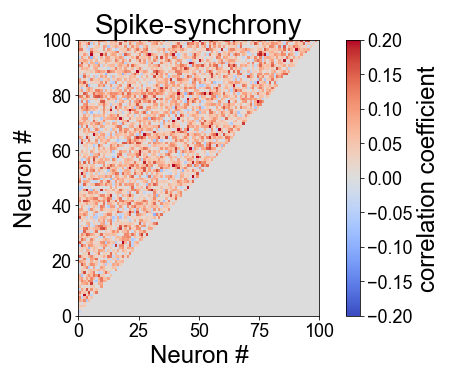

In [14]:
# compute norm for colorbar
limit = np.max(np.abs(corr_mat))*0.2
norm = TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)

fig, ax = plt.subplots(figsize=[6,5])
ax.pcolormesh(np.tril(corr_mat, -1), cmap='coolwarm', norm=norm)
fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax, label='correlation coefficient')
ax.set(xlabel='Neuron #',ylabel='Neuron #')
ax.set_title('Spike-synchrony')

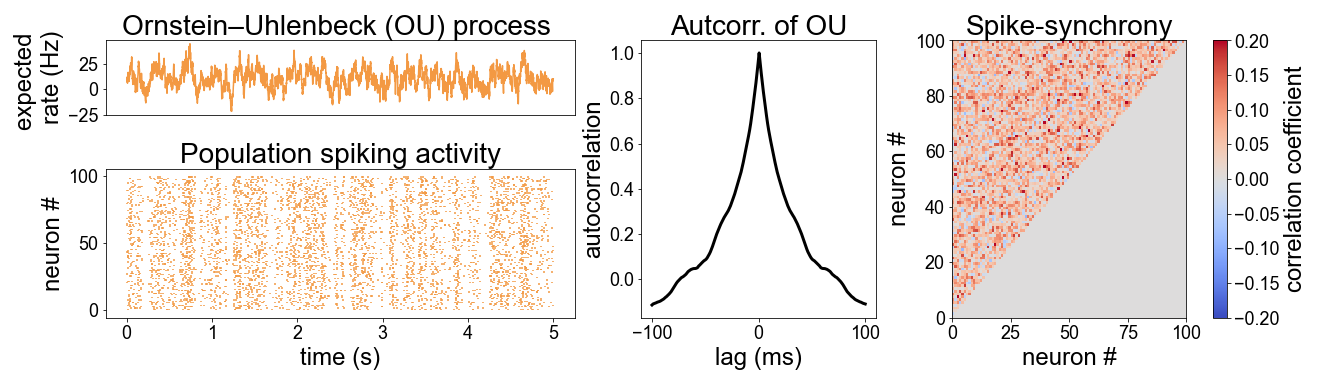

In [15]:
# create figure and gridspec
fig = plt.figure(figsize=[18,5])
spec = gridspec.GridSpec(figure=fig, ncols=3, nrows=2, height_ratios=[1,2], width_ratios=[2,1,1])
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[:,1])
ax4 = fig.add_subplot(spec[:,2])

# plot subplot 1
ax1.plot(time, rand_process, color=COLORS[2])
ax1.set(xlabel="", ylabel="expected \nrate (Hz)")
ax1.set_title("Ornstein–Uhlenbeck (OU) process ")
# ax1.set_title("OU process ")
ax1.set_xticks([])

# plot subplot 2
ax2.eventplot(spike_times, color=COLORS[2])
ax2.set(xlabel="time (s)", ylabel="neuron #")
ax2.set_title('Population spiking activity')

# plot subplot 3
ax3.plot(lags*FS/1000, xcorr, color='k', linewidth=3)
ax3.set(xlabel="lag (ms)", ylabel="autocorrelation")
ax3.set_title('Autcorr. of OU')

# plot subplot 4
ax4.pcolormesh(np.tril(corr_mat, -1), cmap='coolwarm', norm=norm)
fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax4, label='correlation coefficient')
ax4.set(xlabel='neuron #',ylabel='neuron #')
ax4.set_title('Spike-synchrony')

# save
plt.savefig(DIR_FIG + '/panel_0_fig0.png')